In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

In [55]:
# Список функций
def f1(x):
    """f(x) = sin(pi * x) + x^2"""
    return np.sin(np.pi * x) + x**2

def f2(x):
    """f(x) = exp(-x^2)"""
    return np.exp(-x**2)

def f3(x):
    """f(x) = x * sin(5 * x)"""
    return x * np.sin(5 * x)

def f4(x):
    """f(x, y) = sin(pi * x) + y^2"""
    return np.sin(np.pi * x[:, 0]) + x[:, 1]**2

def f5(x):
    """f(x, y) = exp(sin(pi * x) + y^2) — как в hellokan"""
    return np.exp(np.sin(np.pi * x[:, 0]) + x[:, 1]**2)

FUNCTIONS = [
    (f1, 1, "sin(pi*x) + x^2", "D1N1"),
    (f2, 1, "exp(-x^2)", "D1N2"),
    (f3, 1, "x * sin(5*x)", "D1N3"),
    (f4, 2, "sin(pi*x) + y^2", "D2N1"),
    (f5, 2, "exp(sin(pi*x) + y^2)", "D2N1"),
]

In [63]:
def generate_dataset_with_gap(
    func_idx=0,
    n_samples=1000,
    noise_level=0.1,
    x_ranges=None,
    gap_range=None,
    seed=42
):
    np.random.seed(seed)
    func, n_var, name, id_name = FUNCTIONS[func_idx]

    if x_ranges is None:
        x_ranges = [[-2, 2]] if n_var == 1 else [[-2, 2], [-2, 2]]
    
    extra = int(n_samples * 0.3) if gap_range else 0
    N = n_samples + extra

    X = np.column_stack([
        np.random.uniform(low, high, N)
        for low, high in x_ranges
    ])

    if gap_range is not None:
        mask = (X[:, 0] >= gap_range[0]) & (X[:, 0] <= gap_range[1])
        X = X[~mask]
    X = X[:n_samples]

    # Вычисляем y_clean и делаем его одномерным
    if n_var == 1:
        y_clean = func(X.flatten())
    else:
        y_clean = func(X)
    
    y_clean = np.atleast_1d(y_clean).flatten()

    noise = np.random.normal(0, noise_level, y_clean.shape)
    y_noisy = y_clean + noise

    # Создаём DataFrame
    data = {}
    for i in range(n_var):
        data[f'x{i+1}'] = X[:, i]
    data['y'] = y_noisy

    df = pd.DataFrame(data)
    return df, name, id_name

def plot_dataset_with_gap(df, name, gap_range=None, show_plot=True):
    n_vars = len([col for col in df.columns if col.startswith('x')])
    
    # Находим функцию по имени
    func = None
    for f, _, fname, _ in FUNCTIONS:
        if fname == name:
            func = f
            break
    if func is None:
        raise ValueError(f"Функция с именем '{name}' не найдена в FUNCTIONS")

    plt.figure(figsize=(8, 6))
    
    if n_vars == 1:
        x = df['x1'].values
        y = df['y'].values
        plt.scatter(x, y, s=15, alpha=0.6, label='Данные')

        x_full = np.linspace(x.min(), x.max(), 500)
        y_full = func(x_full)
        plt.plot(x_full, y_full, 'r', linewidth=2, label='Идеальная')

        if gap_range:
            plt.axvspan(gap_range[0], gap_range[1], color='gray', alpha=0.2, label='Пропуск')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'1D: {name} (с пропуском)' if gap_range else f'1D: {name}')
        plt.legend()
        plt.grid(True)
    
    elif n_vars == 2:
        x1 = df['x1'].values
        x2 = df['x2'].values
        y = df['y'].values

        ax = plt.axes(projection='3d')
        scatter = ax.scatter(x1, x2, y, c=y, cmap='viridis', s=10, alpha=0.6)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('y')
        ax.set_title(f'2D: {name} (с пропуском)' if gap_range else f'2D: {name}')

        x1_grid = np.linspace(x1.min(), x1.max(), 30)
        x2_grid = np.linspace(x2.min(), x2.max(), 30)
        X1, X2 = np.meshgrid(x1_grid, x2_grid)
        X = np.column_stack([X1.ravel(), X2.ravel()])
        Y_full = func(X).reshape(X1.shape)
        ax.plot_surface(X1, X2, Y_full, color='red', alpha=0.3, linewidth=0)

        if gap_range:
            xx = np.linspace(gap_range[0], gap_range[1], 10)
            yy = np.linspace(x2.min(), x2.max(), 10)
            Xg, Yg = np.meshgrid(xx, yy)
            Zg = np.full_like(Xg, y.min())
            ax.plot_surface(Xg, Yg, Zg, color='gray', alpha=0.1)

        plt.colorbar(scatter, ax=ax, shrink=0.5)

    plt.tight_layout()
    
    if show_plot:
        plt.show()

def save_dataset_and_plots(df, name, id_name, save_dir, noise_level, n_samples, gap_range=None):
    """
    Сохраняет CSV и график, используя id_name (последний элемент FUNCTIONS) в имени файла.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Очистка id_name от спецсимволов
    clean_id = re.sub(r'[^\w]', '_', id_name)
    gap_str = f"gap{gap_range[0]}_{gap_range[1]}" if gap_range else "nogap"
    base_name = f"data_{clean_id}_noise{noise_level}_{gap_str}_n{n_samples}"

    # Сохранение CSV
    csv_path = os.path.join(save_dir, base_name + ".csv")
    df.to_csv(csv_path, index=False)
    print(f"Данные сохранены: {csv_path}")

    # Сохранение графика
    plot_dataset_with_gap(df, name, gap_range=gap_range, show_plot=False)
    png_path = os.path.join(save_dir, base_name + ".png")
    plt.savefig(png_path, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"График сохранён: {png_path}")

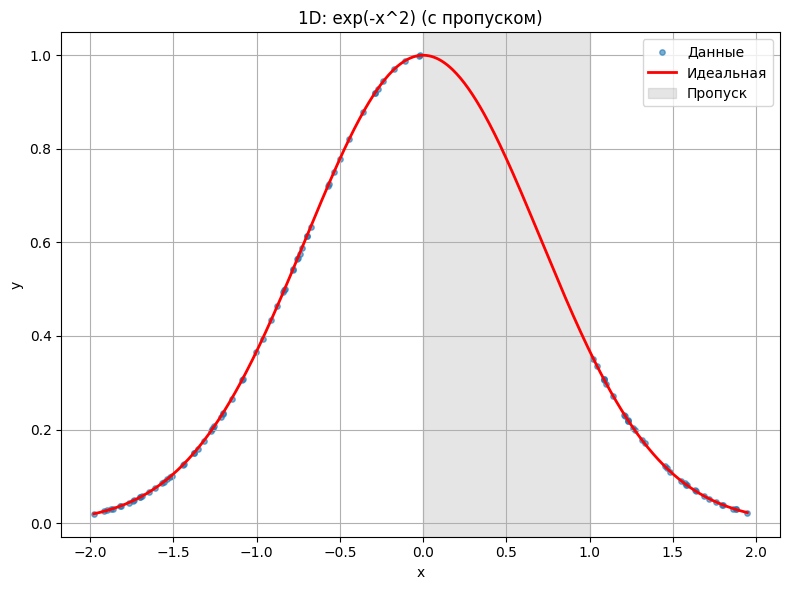

Данные сохранены: ./datasets\data_D1N2_noise0.0_gap0_1_n100.csv
График сохранён: ./datasets\data_D1N2_noise0.0_gap0_1_n100.png


In [64]:
func_ind = 1
noise_level = 0.0
n_samples = 100
gap_range= [0, 1]
path = "./datasets"

df, name, id_name = generate_dataset_with_gap(
    func_idx=func_ind,          # f5: exp(sin(pi*x) + y^2)
    n_samples=n_samples,
    noise_level=noise_level,
    gap_range=gap_range,
    seed=42
)
plot_dataset_with_gap(df, name, gap_range=gap_range, show_plot=True)
# Сохранение (используется id_name = "D2N1")
save_dataset_and_plots(
    df=df,
    name=name,
    id_name=id_name,
    save_dir=path,
    noise_level=noise_level,
    n_samples=n_samples,
    gap_range=gap_range,
)

In [39]:
save_dataset_and_plots(
    df=df,
    name=name,
    save_dir=path,          # ← ваш путь
    noise_level=noise_level,
    n_samples=n_samples,
    gap_range=gap_range
)

Данные сохранены: ./datasets\data_sin_pi_x____y_2_noise0.0100.csv
График сохранён: ./datasets\data_sin_pi_x____y_2_noise0.0100.png


In [66]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Ваши функции здесь (f1...f5) ---
def f1(x): return np.sin(np.pi * x) + x**2
def f2(x): return np.exp(-x**2)
def f3(x): return x * np.sin(5 * x)
def f4(x): return np.sin(np.pi * x[:, 0]) + x[:, 1]**2
def f5(x): return np.exp(np.sin(np.pi * x[:, 0]) + x[:, 1]**2)

FUNCTIONS = [
    (f1, 1, "sin(pi*x) + x^2", "D1N1"),
    (f2, 1, "exp(-x^2)", "D1N2"),
    (f3, 1, "x * sin(5*x)", "D1N3"),
    (f4, 2, "sin(pi*x) + y^2", "D2N1"),
    (f5, 2, "exp(sin(pi*x) + y^2)", "D2N2"),
]

# --- Параметры перебора ---
func_indices = list(range(len(FUNCTIONS)))          # [0, 1, 2, 3, 4]
n_samples_list = [100, 200, 400, 500]
noise_levels = [0,0.05,0.1,0.3,0.5]           # 0.0, 0.05, ..., 0.5
gap_ranges = [None, [-1, 1], [0.5, 1]]              # включая "без пропуска"
path = "./datasets"

total = (len(func_indices) *
         len(n_samples_list) *
         len(noise_levels) *
         len(gap_ranges))

print(f"Начинаем генерацию {total} наборов данных...")
counter = 0

for func_idx in func_indices:
    for n_samples in n_samples_list:
        for noise_level in noise_levels:
            for gap_range in gap_ranges:
                counter += 1
                try:
                    df, name, id_name = generate_dataset_with_gap(
                        func_idx=func_idx,
                        n_samples=n_samples,
                        noise_level=noise_level,
                        gap_range=gap_range,
                        seed=42
                    )
                    save_dataset_and_plots(
                        df=df,
                        name=name,
                        id_name=id_name,
                        save_dir=path,
                        noise_level=round(noise_level, 2),
                        n_samples=n_samples,
                        gap_range=gap_range,
                    )
                    print(f"[{counter}/{total}] Сохранено: {id_name}, N={n_samples}, noise={noise_level:.2f}, gap={gap_range}")
                except Exception as e:
                    print(f"[ОШИБКА {counter}/{total}]: func={func_idx}, N={n_samples}, noise={noise_level}, gap={gap_range} — {e}")
                    continue

print("Генерация завершена!")

Начинаем генерацию 300 наборов данных...
Данные сохранены: ./datasets\data_D1N1_noise0_nogap_n100.csv
График сохранён: ./datasets\data_D1N1_noise0_nogap_n100.png
[1/300] Сохранено: D1N1, N=100, noise=0.00, gap=None
Данные сохранены: ./datasets\data_D1N1_noise0_gap-1_1_n100.csv
График сохранён: ./datasets\data_D1N1_noise0_gap-1_1_n100.png
[2/300] Сохранено: D1N1, N=100, noise=0.00, gap=[-1, 1]
Данные сохранены: ./datasets\data_D1N1_noise0_gap0.5_1_n100.csv
График сохранён: ./datasets\data_D1N1_noise0_gap0.5_1_n100.png
[3/300] Сохранено: D1N1, N=100, noise=0.00, gap=[0.5, 1]
Данные сохранены: ./datasets\data_D1N1_noise0.05_nogap_n100.csv
График сохранён: ./datasets\data_D1N1_noise0.05_nogap_n100.png
[4/300] Сохранено: D1N1, N=100, noise=0.05, gap=None
Данные сохранены: ./datasets\data_D1N1_noise0.05_gap-1_1_n100.csv
График сохранён: ./datasets\data_D1N1_noise0.05_gap-1_1_n100.png
[5/300] Сохранено: D1N1, N=100, noise=0.05, gap=[-1, 1]
Данные сохранены: ./datasets\data_D1N1_noise0.05_gap0